<a href="https://colab.research.google.com/github/ZuzannaNogala/MCARD/blob/master/MCARD_Nogala_l5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# LIST NR 5: Linear Regression (and extensions), classification and Neural Networks in PyTorch.

Zuzanna Nogala

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

import time

from keras.datasets import mnist # <-- dataset from here, 28x28 images

# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Load data

In [73]:
# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# LOAD DATA:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train.shape = ", x_train.shape)
print("x_test.shape = ", x_test.shape)

# We consider only classes 0 and 1
x_train2 = x_train[(y_train == 0) | (y_train == 1)]
y_train2 = y_train[(y_train == 0) | (y_train == 1)]

x_test2 = x_test[(y_test == 0) | (y_test == 1)]
y_test2 = y_test[(y_test == 0) | (y_test == 1)]

# nr of samples, size  of images
n_samples_train, h, w = x_train2.shape
n_samples_test, _, _ = x_test2.shape
print("images of size: h= ", h, ", w = ", w)

# reshape nr_samples * "vectorized image"
num_features = h*w
x_train2 = x_train2.reshape((-1, h*w))
x_test2 = x_test2.reshape((-1, h*w))

print("x_train2.shape = ", x_train2.shape)
print("x_test2.shape = ", x_test2.shape)

# normalizing data by number of pixels
x_train2 = x_train2 / 255
x_test2 = x_test2 / 255

x_train.shape =  (60000, 28, 28)
x_test.shape =  (10000, 28, 28)
images of size: h=  28 , w =  28
x_train2.shape =  (12665, 784)
x_test2.shape =  (2115, 784)


# Q5.1 (10 pts)

* Above we implemented logistic regression as the following  network with 1  neuron:
```python
model_lr_torch = nn.Sequential(
    nn.Linear(num_features,1),
    nn.Sigmoid()).to(device)
```
* **Task** Reimplement  the model using:
```python
model_lr_torch_v2 = nn.Sequential(
    nn.Linear(num_features,1)    
```
* Since the output is now a raw real number (logit), adjust the loss function accordingly. Compare the results with those from `model_lr_torch`
* *Hint*: When computing $\log(s)$ in practice, to avoid numerical issues (such as $\log(0)$), add a small constant and compute  $\log(s+\textrm{eps})$ instead. A recommended value is: `eps=1e-7`

In [3]:
# MODELS WITH LOGIT LINK:
model_lr_torch = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid())

# MODELS WITH ONLY LINEAR LINK:
model_lr_torch_v2 = nn.Sequential(
  nn.Linear(num_features, 1),
)

In [6]:
# TRAINER OF MODEL
class MyTorchClassifierTrainer:

    def __init__(self, model, dataloader=None, lr=0.01, num_epochs=150, loss_function=nn.BCELoss()):
        self.model = model
        self.dataloader = dataloader
        self.num_epochs = num_epochs
        self.lr = lr
        self.loss_history = []
        self.loss_function = loss_function

    def create_dataloader(self, x_train, y_train, batch_size=128):
        x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

        dataset = TensorDataset(x_train_tensor, y_train_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.dataloader = dataloader

    def fit(self, verbose=True):
        print(f"TRAINING MODEL... ")

        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        loss_history = []

        for epoch in range(self.num_epochs):

            self.model.train()
            epoch_loss = 0.0

            for batch_X, batch_y in self.dataloader:
                # Zero the gradients
                optimizer.zero_grad()
                # Forward pass
                output_probs = self.model(batch_X)

                loss = self.loss_function(output_probs, batch_y)

                # Backward pass and update
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_loss = epoch_loss / len(self.dataloader)
            loss_history.append(average_loss)
            if verbose:
                if (epoch + 1) % 20 == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Loss: {average_loss:.6f}')

    def predict(self, x_test):
        self.model.eval()
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
        with torch.no_grad():
          predictions = self.model(x_test_tensor)
        return predictions

In [7]:
# TRAINING MODEL model_lr_torch
# Creating trainer object for model_lr_torch (model with nn.Sigmoid())
model_lr_torch_training = MyTorchClassifierTrainer(model=model_lr_torch)

# Create a TensorDataset and DataLoader for model_lr_torch (the same dataloader will be used for the second model)
model_lr_torch_training.create_dataloader(x_train2, y_train2)
dataloader = model_lr_torch_training.dataloader

# TRAINING model_lr_torch
start_time = datetime.now()
model_lr_torch_training.fit()
time_elapsed = datetime.now() - start_time
print('TRAINING TIME (hh:mm:ss.ms) {}'.format(time_elapsed))

TRAINING MODEL... 
Epoch [20/150], Loss: 0.000648
Epoch [40/150], Loss: 0.000171
Epoch [60/150], Loss: 0.000059
Epoch [80/150], Loss: 0.000023
Epoch [100/150], Loss: 0.000049
Epoch [120/150], Loss: 0.000003
Epoch [140/150], Loss: 0.000002
TRAINING TIME (hh:mm:ss.ms) 0:00:39.431948


In [8]:
# TRAINING MODEL model_lr_torch_v2
# Creating trainer object for model_lr_torch_v2 with previous used dataloader
model_lr_torch_v2_training = MyTorchClassifierTrainer(model=model_lr_torch_v2,
                                                      dataloader=dataloader,
                                                      loss_function=nn.BCEWithLogitsLoss()) # modified loss function

# TRAINING model_lr_torch_v2
start_time = datetime.now()
model_lr_torch_v2_training.fit()
time_elapsed = datetime.now() - start_time
print('TRAINING TIME (hh:mm:ss.ms) {}'.format(time_elapsed))

TRAINING MODEL... 
Epoch [20/150], Loss: 0.000629
Epoch [40/150], Loss: 0.000167
Epoch [60/150], Loss: 0.000059
Epoch [80/150], Loss: 0.000025
Epoch [100/150], Loss: 0.000009
Epoch [120/150], Loss: 0.000004
Epoch [140/150], Loss: 0.000001
TRAINING TIME (hh:mm:ss.ms) 0:00:31.117820


In [17]:
# COMPARISON OF ACCURACY
x_test2_pred_output_probs = model_lr_torch_training.predict(x_test2)
x_test2_pred_output_probs_v2 = model_lr_torch_v2_training.predict(x_test2)

x_test2_pred_output_classes = (x_test2_pred_output_probs > 0.5)
x_test2_pred_output_classes_v2 = (nn.Sigmoid()(x_test2_pred_output_probs_v2) > 0.5)
# model_lr_torch_v2 - real predictions, therefore we use nn.Sigmoid() functions on predictions

print(f"Predictions of first 5 pictures from model_lr_torch: {x_test2_pred_output_probs.flatten()[1:5]}")
print(f"Predictions of first 5 pictures from model_lr_torch_v2: {x_test2_pred_output_probs_v2.flatten()[1:5]}")

print(" ")

print("model_lr_torch (classification of 0 and 1 digits): accuracy  =  \t",
      accuracy_score(x_test2_pred_output_classes, y_test2))
print("model_lr_torch_v2 (classification of 0 and 1 digits): accuracy  =  \t",
      accuracy_score(x_test2_pred_output_classes_v2, y_test2))

Predictions of first 5 pictures from model_lr_torch: tensor([9.7863e-19, 1.0000e+00, 6.8066e-18, 1.7636e-16])
Predictions of first 5 pictures from model_lr_torch_v2: tensor([-40.8445,  21.3824, -39.4365, -35.9686])
 
model_lr_torch (classification of 0 and 1 digits): accuracy  =  	 0.9995271867612293
model_lr_torch_v2 (classification of 0 and 1 digits): accuracy  =  	 0.9995271867612293


In [21]:
# COMPARISON OF BCE OF MODELS (computing by hand):
# BCE = -mean( y*log(prob) + (1-y)*log(1-prob))
eps = 1e-7
y_test2_tensor = torch.tensor(y_test2, dtype=torch.float32).unsqueeze(1)  # shape (N,1)

BCE_torch = -torch.mean(
    y_test2_tensor * torch.log(x_test2_pred_output_probs + eps) +
    (1 - y_test2_tensor) * torch.log(1 - x_test2_pred_output_probs + eps)
)

# torch.sigmoid is applied on predictions from model_lr_torch_v2
BCE_torch_v2 = -torch.mean(
    y_test2_tensor * torch.log(torch.sigmoid(x_test2_pred_output_probs_v2) + eps) +
    (1 - y_test2_tensor) * torch.log(1 - torch.sigmoid(x_test2_pred_output_probs_v2) + eps)
)
print("PyTorch BCE on x_test2 - model_lr_torch = ", BCE_torch.item())
print("PyTorch BCE on x_test2 - model_lr_torch_v2 = ", BCE_torch_v2.item())

PyTorch BCE on x_test2 - model_lr_torch =  0.0022953697480261326
PyTorch BCE on x_test2 - model_lr_torch_v2 =  0.0026996550150215626


Sum(|nn_coef|) LC:  556.8666
Sum(|nn_coef_v2|) LC:  560.5941


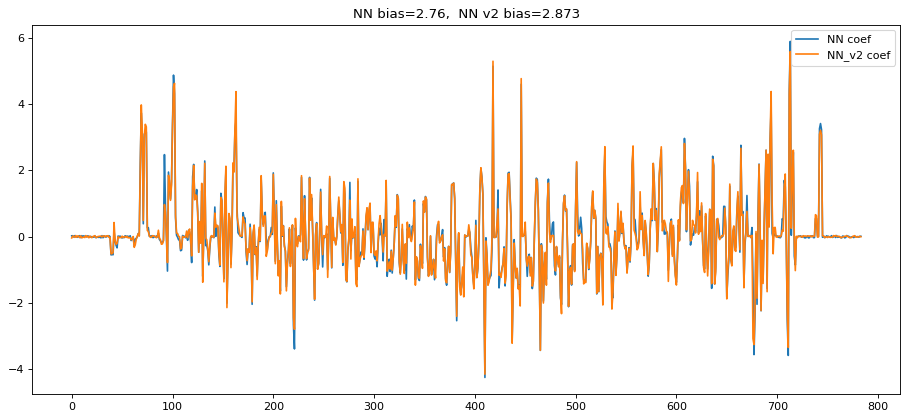

In [22]:
# PLOT OF MODELS COEFFICIENTS AND BIAS:
nn_coef = model_lr_torch[0].weight.detach().cpu().numpy().reshape(-1)
nn_bias = model_lr_torch[0].bias.detach().cpu().numpy()[0]

nn_coef_v2 = model_lr_torch_v2[0].weight.detach().cpu().numpy().reshape(-1)
nn_bias_v2 = model_lr_torch_v2[0].bias.detach().cpu().numpy()[0]

plt.figure(figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.arange(h*w), nn_coef, label="NN coef")
plt.plot(np.arange(h*w), nn_coef_v2, label="NN_v2 coef")
plt.title("NN bias="+str(np.round(nn_bias, 3)) + ",  NN v2 bias="+str(np.round(nn_bias_v2, 3)))

print("Sum(|nn_coef|) LC: ", np.sum(np.abs(nn_coef)))
print("Sum(|nn_coef_v2|) LC: ", np.sum(np.abs(nn_coef_v2)))

plt.legend()
plt.show()

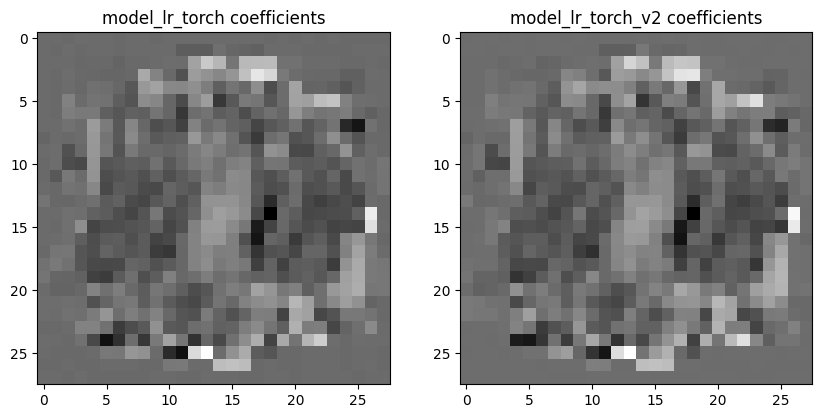

In [23]:
# PLOT OF MODELS COEFFICIENTS IN GRAY SCALE:
f = plt.figure(figsize=(10, 10))

ax1 = f.add_subplot(1, 2, 1)
ax1.imshow(nn_coef.reshape(h, w), cmap='gray')
ax1.set_title("model_lr_torch coefficients")

ax2 = f.add_subplot(1, 2, 2)
ax2.imshow(nn_coef_v2.reshape(h, w), cmap='gray')
ax2.set_title("model_lr_torch_v2 coefficients")

plt.show()

# Q5.2 (10 pts)
**Q5.2 STARTS**

* Implement a neural network with the same architecture as `model_4digits_torch_2_layers, but without using `torch.nn` modules

* It is convenient first to augment data -- currently we have 784 features, we will add one extra column (first one) with fixed value of 1:

**More details:**

In [70]:
num_classes = 4 # CLASSES 0, 1, 2, 3

model_4digits_torch_2_layers = nn.Sequential(
    nn.Linear(num_features, 128), #num_features = 28x28 = 784
    nn.ReLU(),
    nn.Linear(128, num_classes),
    nn.Softmax(dim=1)  # Output probabilities
).to(device)

*  The original input vector has 784 features, denote augmented input as $\mathbf{x}_{\text{aug}}$:
* $$
\mathbf{x} =
\begin{bmatrix}
x_1 \\ x_2 \\ \vdots \\ x_{784}
\end{bmatrix} \in \mathbb{R}^{784},
\qquad
\mathbf{x}_{\text{aug}} =
\begin{bmatrix}
1 \\ x_1 \\ x_2 \\ \vdots \\ x_{784}
\end{bmatrix} \in \mathbb{R}^{785}.
$$
* Define the first weight matrix
$
\mathbf{W}_1 \in \mathbb{R}^{785 \times 128}.
$
*Compute the hidden representation using the ReLU activation:
$$
\mathbf{H} = \operatorname{ReLU}\left( \mathbf{x}_{\text{aug}}^\top \mathbf{W}_1 \right).
$$
* **Hint:** Use `torch.relu` to perform the ReLU operation element-wise.
* Next, to incorporate the bias for the hidden-to-output layer, augment the hidden representation by prepending 1. Denote this augmented hidden representation by
$
\mathbf{H}_{\text{aug}} \in \mathbb{R}^{129}\quad (\text{since } 128+1 = 129).
$
* Define the second weight matrix
$$
\mathbf{W}_2 \in \mathbb{R}^{129 \times 4}.
$$
* Compute the output logits as follows:
$$
\mathbf{y}_{\text{logits}} = \mathbf{H}_{\text{aug}}^\top \mathbf{W}_2.
$$
Finally, obtain the class probabilities by applying the softmax function:
$$
\mathbf{y}_{\text{probs}} = \operatorname{softmax}\left(\mathbf{y}_{\text{logits}}\right).
$$
* Your **task** is to implement this network using only `PyTorch` tensor operations (i.e., matrix multiplications) without any `torch.nn` layers. Augment the input data as described, define and initialize the matrices ($\textbf{W}$ for weights and $\textbf{H}$ for the hidden representation) properly, compute the forward pass using `torch.relu` for the activation, and use an optimizer (e.g., `torch.optim.Adam` to update the weight matrices during training on a dataset with one-hot encoded targets.
* Below a template for solution is written, "just" write function `forward()`



In [74]:
x_trainM, y_trainM = x_train, y_train
x_testM, y_testM = x_test, y_test

# CLASSES 0, 1, 2, 3
x_trainM, y_trainM = x_train[y_train <= 3], y_train[y_train <= 3]
x_testM, y_testM = x_test[y_test <= 3], y_test[y_test <= 3]


# nr of samples, size  of images
n_samples_trainM, h, w = x_trainM.shape
n_samples_testM, _, _ = x_testM.shape
print("images of size: h= ", h, ", w = ", w)

num_features = h*w

x_trainM = x_trainM.reshape((-1, h*w))
x_testM = x_testM.reshape((-1, h*w))

print("x_trainM.shape = ", x_trainM.shape)
print("x_testM.shape = ", x_testM.shape)

# normalizing
x_trainM = x_trainM / 255
x_testM = x_testM / 255

images of size: h=  28 , w =  28
x_trainM.shape =  (24754, 784)
x_testM.shape =  (4157, 784)


In [75]:
def categorical_crossentropy(predictions, targets, eps=1e-7):
    # predictions are probabilities, targets are one-hot encoded
    return -torch.mean(torch.sum(targets * torch.log(predictions + eps), dim=1))

In [76]:
class MyTwoLayerNNClassifier:

    def __init__(self, first_layer_size, n_classes, lr=0.001, n_epochs=20, batch_size=16):
        self.lr = lr
        self.batch_size = batch_size
        self.first_layer_size = first_layer_size
        self.n_classes = n_classes
        self.n_epochs = n_epochs
        self.W1 = None
        self.W2 = None

    def forward(self, x_batch):
        H = torch.matmul(x_batch, self.W1)  # 16x785, 785x128
        H_relu = torch.relu(H)

        # Augment H_relu by adding a column of ones at the beginning (for bias)
        ones = torch.ones(H_relu.shape[0], 1)
        H_aug = torch.cat((ones, H_relu), dim=1)  # 16 x 129

        y_logis = torch.matmul(H_aug, self.W2)  # 16 x 129, 129 x 4
        y_pred = torch.softmax(y_logis, dim=1)

        return y_pred

    def fit(self, x_train, y_train, verbose=True):
        x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)

        ones_column = torch.ones(x_train_tensor.size(0), 1)

        x_train_tensor_augmented = torch.cat((ones_column, x_train_tensor), dim=1)
        y_train_one_hot = F.one_hot(y_train_tensor, num_classes=self.n_classes).float()

        train_dataset_augmented = TensorDataset(x_train_tensor_augmented, y_train_one_hot)
        train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=self.batch_size, shuffle=True)

        self.W1 = torch.randn(x_train_tensor.size(1) + 1, self.first_layer_size, requires_grad=True)
        self.W2 = torch.randn(self.first_layer_size + 1, self.n_classes, requires_grad=True)

        optimizer = optim.Adam([self.W1, self.W2], lr=self.lr)

        print(f"TRAINING MODEL... ")

        for epoch in range(self.n_epochs):
            running_loss = 0.0

            for batch_x, batch_y in train_loader_augmented:
                optimizer.zero_grad()
                preds_batch = self.forward(batch_x)
                loss = categorical_crossentropy(preds_batch, batch_y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * batch_x.size(0)
            epoch_loss = running_loss / len(train_dataset_augmented)

            if verbose:
                print(f"Epoch {epoch + 1}/{self.n_epochs}, Loss: {epoch_loss:.6f}")

    def predict(self, x_test):
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
        x_test_tensor_aug = torch.cat((torch.ones(x_test_tensor.size(0), 1), x_test_tensor), dim=1)

        with torch.no_grad():
          preds_test = self.forward(x_test_tensor_aug)
          predicted_classes = preds_test.argmax(dim=1)
        return predicted_classes

In [43]:
# TRAINING
model = MyTwoLayerNNClassifier(first_layer_size=128, n_classes=4, n_epochs=20)

start_time = datetime.now()
model.fit(x_trainM, y_trainM)
time_elapsed = datetime.now() - start_time
print('TRAINING TIME (hh:mm:ss.ms) {}'.format(time_elapsed))

TRAINING MODEL... 
Epoch 1/20, Loss: 1.470866
Epoch 2/20, Loss: 0.580492
Epoch 3/20, Loss: 0.428717
Epoch 4/20, Loss: 0.360060
Epoch 5/20, Loss: 0.313312
Epoch 6/20, Loss: 0.265896
Epoch 7/20, Loss: 0.236152
Epoch 8/20, Loss: 0.235719
Epoch 9/20, Loss: 0.214863
Epoch 10/20, Loss: 0.190017
Epoch 11/20, Loss: 0.177643
Epoch 12/20, Loss: 0.162651
Epoch 13/20, Loss: 0.141571
Epoch 14/20, Loss: 0.134739
Epoch 15/20, Loss: 0.130756
Epoch 16/20, Loss: 0.116043
Epoch 17/20, Loss: 0.105383
Epoch 18/20, Loss: 0.101693
Epoch 19/20, Loss: 0.096155
Epoch 20/20, Loss: 0.096007
TRAINING TIME (hh:mm:ss.ms) 0:01:48.507706


In [44]:
# CHECK ACCURACY ON TEST SET
predicted_classes = model.predict(x_testM)

print("W1, W2, accuracy  = \t", accuracy_score(predicted_classes,y_testM),
      " correctly cl. cases=", np.sum(predicted_classes.detach().numpy() == y_testM))

W1, W2, accuracy  = 	 0.9886937695453452  correctly cl. cases= 4110


# Q5.3
**Q5.3 STARTS**
* In this task you will classify `Wine dataset`, which is a 3-class dataset (wines from 3 different cultivars) comprising 178 samples with 13 chemical features each.
* First, let us read in dataset, split it into train and test set, and transform it to torch:

* **TASK** Create a simple three-layer network with the following architecture:

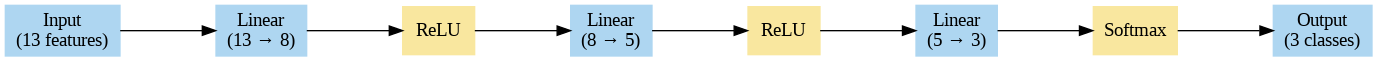

* Train the model with `Adam` optimizer with `lr=0.01` for `n_epochs=500`.
* Compute final accuracy. Check if decreasing batch size (e.g., `batch_size=16`) improves the results.

In [50]:
# Load Wine dataset: 178 samples, 13 features, 3 classes.
wine = load_wine()
X = wine.data
y = wine.target

num_classes = 3

# Split into train/test (80%/20%) with stratification.
# keeping the same percentage of each class in train/test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Original y_test: {y_test}")

# Convert data to torch tensors.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# One-hot encode target labels (for 3 classes).
y_train_tensor = F.one_hot(y_train_tensor, num_classes=3).float()
y_test_tensor = F.one_hot(y_test_tensor, num_classes=3).float()

Original y_test: [0 2 0 1 1 0 0 1 1 2 1 2 0 2 0 1 1 0 1 0 1 1 0 0 1 1 0 2 1 2 0 2 1 2 2 2]


In [51]:
def create_dataloader(dataset, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def accuracy_and_predictions_model(model, x_test_tensor=X_test_tensor, Y_test=y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test_tensor.to(device))
        # Get predicted classes by taking argmax
        torch_preds = test_outputs.argmax(dim=1).cpu().numpy()
        print(f"predictions of y_test: {torch_preds}")

    # Accuracy:
    print("accuracy  = \t\t", accuracy_score(torch_preds, Y_test),
          "correctly cl. cases=", np.sum(torch_preds == Y_test), " out of ", len(Y_test))

    return accuracy_score(torch_preds, Y_test)

In [59]:
# Model 1 - training with batch_size = 128

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = create_dataloader(train_dataset, batch_size=128)

WineClassifer_torch_model = nn.Sequential(
    nn.Linear(13, 8),
    nn.ReLU(),
    nn.Linear(8, 5),
    nn.ReLU(),
    nn.Linear(5, num_classes),
    nn.Softmax(dim=1)
).to(device)

In [63]:
print("MODEL 1 (batch_size=128)")

training1 = MyTorchClassifierTrainer(model=WineClassifer_torch_model,
                                     dataloader=train_loader,
                                     num_epochs=500,
                                     loss_function=categorical_crossentropy)

start_time = time.time()
training1.fit(verbose=True)
print("PyTorch training took {:.2f} seconds".format(time.time() - start_time))

print(" ")

print(f"Original y_test: {y_test}")
accuracy_and_predictions_model(WineClassifer_torch_model)

MODEL 1 (batch_size=128)
TRAINING MODEL... 
Epoch [20/500], Loss: 5.074140
Epoch [40/500], Loss: 5.023195
Epoch [60/500], Loss: 5.528792
Epoch [80/500], Loss: 5.016283
Epoch [100/500], Loss: 5.024194
Epoch [120/500], Loss: 7.072957
Epoch [140/500], Loss: 4.501801
Epoch [160/500], Loss: 3.474933
Epoch [180/500], Loss: 5.021167
Epoch [200/500], Loss: 7.062188
Epoch [220/500], Loss: 5.011992
Epoch [240/500], Loss: 5.012181
Epoch [260/500], Loss: 5.024222
Epoch [280/500], Loss: 5.046051
Epoch [300/500], Loss: 0.979928
Epoch [320/500], Loss: 0.739758
Epoch [340/500], Loss: 0.625396
Epoch [360/500], Loss: 0.595020
Epoch [380/500], Loss: 0.565264
Epoch [400/500], Loss: 0.567987
Epoch [420/500], Loss: 0.500760
Epoch [440/500], Loss: 0.494637
Epoch [460/500], Loss: 0.490343
Epoch [480/500], Loss: 0.465432
Epoch [500/500], Loss: 0.645066
PyTorch training took 2.45 seconds
 
Original y_test: [0 2 0 1 1 0 0 1 1 2 1 2 0 2 0 1 1 0 1 0 1 1 0 0 1 1 0 2 1 2 0 2 1 2 2 2]
predictions of y_test: [2 2 0 1 

0.6111111111111112

In [64]:
# Model 2 - training with batch_size = 16

train_loader2 = create_dataloader(train_dataset, batch_size=16)

WineClassifer_torch_model2 = nn.Sequential(
    nn.Linear(13, 8),
    nn.ReLU(),
    nn.Linear(8, 5),
    nn.ReLU(),
    nn.Linear(5, num_classes),
    nn.Softmax(dim=1)
).to(device)

In [65]:
print("MODEL 2 (batch_size=16)")

training2 = MyTorchClassifierTrainer(model=WineClassifer_torch_model2,
                                     dataloader=train_loader2,
                                     num_epochs=500,
                                     loss_function=categorical_crossentropy)

start_time = time.time()
training2.fit(verbose=True)
print("PyTorch training took {:.2f} seconds".format(time.time() - start_time))

print(" ")

print(f"Original y_test: {y_test}")
accuracy_and_predictions_model(WineClassifer_torch_model2)

MODEL 2 (batch_size=16)
TRAINING MODEL... 
Epoch [20/500], Loss: 0.823238
Epoch [40/500], Loss: 0.568463
Epoch [60/500], Loss: 0.581562
Epoch [80/500], Loss: 0.324984
Epoch [100/500], Loss: 0.173237
Epoch [120/500], Loss: 0.178444
Epoch [140/500], Loss: 0.120384
Epoch [160/500], Loss: 0.106863
Epoch [180/500], Loss: 0.114521
Epoch [200/500], Loss: 0.108156
Epoch [220/500], Loss: 0.226432
Epoch [240/500], Loss: 0.074957
Epoch [260/500], Loss: 0.085612
Epoch [280/500], Loss: 0.095077
Epoch [300/500], Loss: 0.088930
Epoch [320/500], Loss: 0.111444
Epoch [340/500], Loss: 0.060261
Epoch [360/500], Loss: 0.242931
Epoch [380/500], Loss: 0.080287
Epoch [400/500], Loss: 0.068907
Epoch [420/500], Loss: 0.554583
Epoch [440/500], Loss: 0.064050
Epoch [460/500], Loss: 0.070114
Epoch [480/500], Loss: 0.102107
Epoch [500/500], Loss: 0.080283
PyTorch training took 7.49 seconds
 
Original y_test: [0 2 0 1 1 0 0 1 1 2 1 2 0 2 0 1 1 0 1 0 1 1 0 0 1 1 0 2 1 2 0 2 1 2 2 2]
predictions of y_test: [0 2 0 1 1

0.9444444444444444

In [66]:
# Average results:

K = 50
acc_results = np.zeros((K, 2))

for i in range(K):
    print(f"Id of Iteration {i}:")

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = create_dataloader(train_dataset, batch_size=128)

    WineClassifer_torch_model = nn.Sequential(
        nn.Linear(13, 8),
        nn.ReLU(),
        nn.Linear(8, 5),
        nn.ReLU(),
        nn.Linear(5, num_classes),
        nn.Softmax(dim=1)
    ).to(device)
    print(" ")
    print("MODEL 1 (batch_size=128)")

    training1 = MyTorchClassifierTrainer(model=WineClassifer_torch_model,
                                         dataloader=train_loader,
                                         num_epochs=500,
                                         loss_function=categorical_crossentropy)

    training1.fit(verbose=False)

    acc_1 = accuracy_and_predictions_model(WineClassifer_torch_model)

    # Model 2 - training with batch_size = 16

    train_loader2 = create_dataloader(train_dataset, batch_size=16)

    WineClassifer_torch_model2 = nn.Sequential(
        nn.Linear(13, 8),
        nn.ReLU(),
        nn.Linear(8, 5),
        nn.ReLU(),
        nn.Linear(5, num_classes),
        nn.Softmax(dim=1)
    ).to(device)

    print(" ")
    print("MODEL 2 (batch_size=16)")

    training2 = MyTorchClassifierTrainer(model=WineClassifer_torch_model2,
                                         dataloader=train_loader2,
                                         num_epochs=500,
                                         loss_function=categorical_crossentropy)

    training2.fit(verbose=False)

    acc_2 = accuracy_and_predictions_model(WineClassifer_torch_model2)

    acc_results[i, :] = [acc_1, acc_2]

Id of Iteration 0:
 
MODEL 1 (batch_size=128)
TRAINING MODEL... 
predictions of y_test: [0 2 0 1 1 0 0 1 1 2 1 2 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 2 1 2 0 2 1 2 2 2]
accuracy  = 		 0.9166666666666666 correctly cl. cases= 33  out of  36
 
MODEL 2 (batch_size=16)
TRAINING MODEL... 
predictions of y_test: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
accuracy  = 		 0.3888888888888889 correctly cl. cases= 14  out of  36
Id of Iteration 1:
 
MODEL 1 (batch_size=128)
TRAINING MODEL... 
predictions of y_test: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
accuracy  = 		 0.3888888888888889 correctly cl. cases= 14  out of  36
 
MODEL 2 (batch_size=16)
TRAINING MODEL... 
predictions of y_test: [0 2 0 1 1 0 0 1 1 2 1 2 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 2 1 2 0 2 1 2 2 2]
accuracy  = 		 0.9166666666666666 correctly cl. cases= 33  out of  36
Id of Iteration 2:
 
MODEL 1 (batch_size=128)
TRAINING MODEL... 
predictions of y_test: [0 2 0 1 1 0 0 1 1 2 1 1

In [69]:
# Average accuracy
avg_results = acc_results.mean(axis=0)

print(f"Average accuracy for batch_size=128: {avg_results[0]}.")
print(f"Average accuracy for batch_size=16: {avg_results[1]}.")

Average accuracy for batch_size=128: 0.5905555555555556.
Average accuracy for batch_size=16: 0.7.
